# State Farm Distracted Driver Detection

**This version refers to a public Kaggle submission: https://www.kaggle.com/code/longvan92/using-resnet-99-success-rate-on-validation-test**

## Libraries

In [ ]:
# support image quality check
!pip install Pillow
# visual process bar
!pip install tqdm

!pip install tensorflow[and-cuda]
!pip install opencv-python

In [1]:
# System Built-in Modules
import os           # Provides a way of using operating system dependent functionality.
import random       # Implements pseudo-random number generators for various distributions.
import shutil       # Offers high-level file operations like copy and move.
import time         # Provides various time-related functions.

# External Modules
from collections import defaultdict
import matplotlib.pyplot as plt  # For creating static, interactive, and animated visualizations.
import numpy as np               # Adds support for large, multi-dimensional arrays and matrices.
import pandas as pd              # Data analysis and manipulation tool.
import PIL.Image                 # Supports opening, manipulating, and saving many image formats.
import seaborn as sns            # Statistical data visualization based on matplotlib.
import torch                     # Open-source machine learning library.
import torch.nn as nn            # Neural network library within PyTorch.
import torchvision               # Datasets, model architectures, and image transformations for computer vision.
# Provides pre-built models, data transformations, and access to standard datasets for computer vision.
from torchvision import models,transforms,datasets
from IPython.display import Image  # Displaying images in Jupyter notebooks.
from sklearn.metrics import confusion_matrix  # For evaluating the accuracy of classification.
from tqdm import tqdm            # Adds progress bars to loops.

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 0. Load Data

In [4]:
df = pd.read_csv('/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv')
df.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


## 1. Data Clean / Understanding
Clean data and Understand the data through statisistics and visualization

### 1.0 Understand classes

In [2]:
path_train = "/kaggle/input/state-farm-distracted-driver-detection/imgs/train"
classes = [c for c in os.listdir(path_train) if not c.startswith(".")]
classes.sort()
print(classes)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


In [3]:
class_dict = {0 : "safe driving",
              1 : "texting - right",
              2 : "talking on the phone - right",
              3 : "texting - left",
              4 : "talking on the phone - left",
              5 : "operating the radio",
              6 : "drinking",
              7 : "reaching behind",
              8 : "hair and makeup",
              9 : "talking to passenger"}

### 1.1 Distribution
Goal: Understand the distribution of columns in the data set.
1. Are all of the  columns normally distributed?

Impacts:
1. If the data is not normally distributed, the training process may be biased towards the majority class.

Precondition:
1. Data is loaded.
2. Missing values are handled.
   a. reason: missing values are not counted in the distribution.

Action: Find the distribution of every column in the data set, totally 3 columns.
1. subject
2. classname
3. img

#### 1.1.1 subject distribution

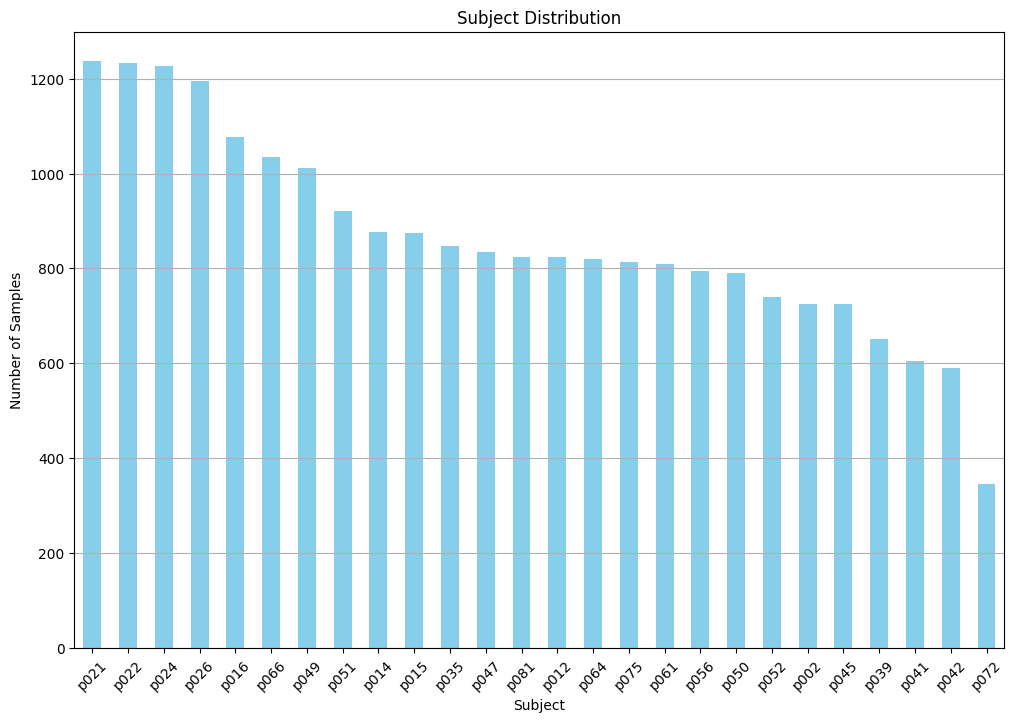

In [7]:
# Count the number of occurrences of each class
class_counts = df['subject'].value_counts()

# Plot the distribution
plt.figure(figsize=(12, 8))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Subject Distribution')
plt.xlabel('Subject')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

#### 1.1.2 classname distribution

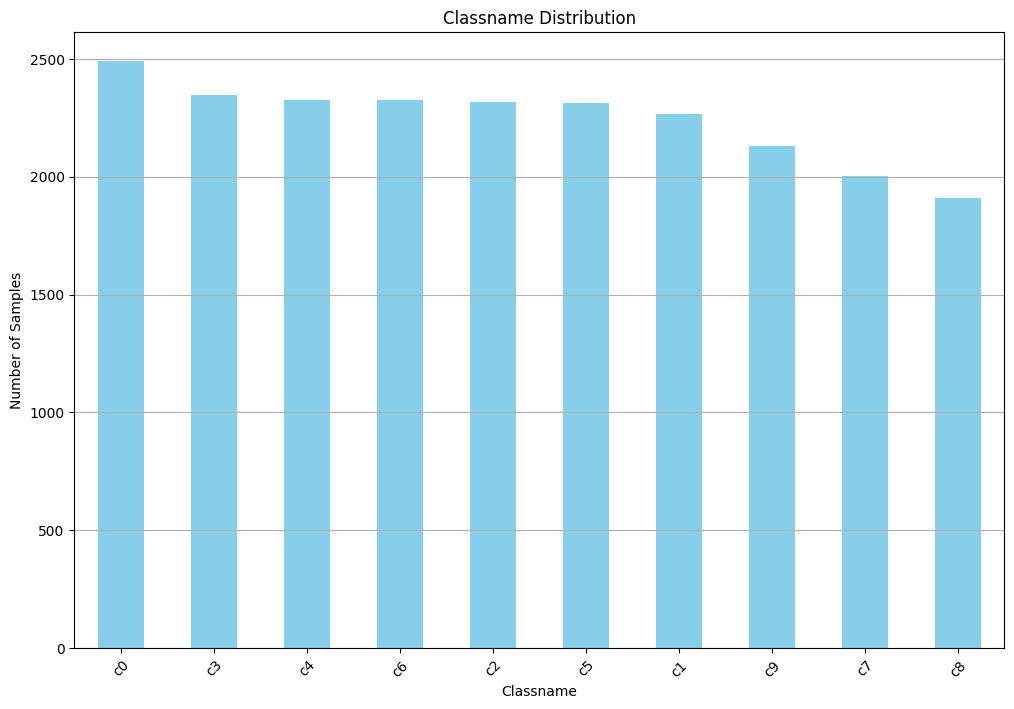

In [8]:
# Count the number of occurrences of each class
class_counts = df['classname'].value_counts()

# Plot the distribution
plt.figure(figsize=(12, 8))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Classname Distribution')
plt.xlabel('Classname')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

#### 1.1.3 img distribution
To visualize it may take quite a long time since img is likely to be unique.
So, instead of render every single bar, we can instead see if every of them are unique.

In [9]:
# Check the total number of 'img' entries
total_entries = len(df['img'])

# Check the number of unique 'img' entries
unique_entries = df['img'].nunique()

# Print the results
print(f"Total number of image entries: {total_entries}")
print(f"Number of unique image entries: {unique_entries}")

# Check if every image entry is unique
if total_entries == unique_entries:
    print("Every image entry is unique.")
else:
    print(f"There are {total_entries - unique_entries} duplicate image entries.")

Total number of image entries: 22424
Number of unique image entries: 22424
Every image entry is unique.


### 1.2 Image Quality Check
**Here might be tricky**

Image Quality Check: 
Check if all images are of 
1. consistent quality, 
2. resolution,
3. orientation. 
4. Identify any corrupted or unreadable images.

**Note**: Based on the suggestion from James, since those image are already labeled, they are very likely to be okay, such the as the resolution, orientation, and the size.

Action:
Just in case, 

1. write the code to check integrity for easy items, such as
  a. if every single img has the same size
  b. resolution same for each img? (how many pixels are displayed per inch of an image)
2. Manually random choose a portion of images (may be quickly galance 1000 images?), to build confidence:
  a. same orientation?
  b. any corrupted data?

### 1.2.1 Coding Part for Cleaning Simple Items
Assignee: Jingchao Zhong

Note for the implementation:
By observation, the `img` column of `driver_imgs_list.csv` only contain the image filenames for the training data set, which means the image files are located in the `imgs/train` folder. Thus, to check the quality of all available imgs, I scan directly for the images under `imgs` folder.

In [18]:
class ImageScanner:
    def __init__(self, path):
        self.path = path
        self.image_files = self._get_all_jpg_files()
        self.statistics = {
            "total_images": len(self.image_files),
            "same_size": 0,
            "different_size": 0,
            "same_resolution": 0,
            "different_resolution": 0,
            "reference_size": None,
            "reference_resolution": None,
            "size_issues": defaultdict(list),
            "resolution_issues": defaultdict(list)
        }

    def _get_all_jpg_files(self):
        """
        Retrieve all jpg files in the specified directory, including subdirectories.
        """
        jpg_files = []
        for root, _, files in os.walk(self.path):
            for file in files:
                if file.lower().endswith(".jpg"):
                    jpg_files.append(os.path.join(root, file))
        return jpg_files

    @staticmethod
    def _get_image_size_and_resolution(image_path):
        """
        Get the size and resolution of an image.
        """
        with PIL.Image.open(image_path) as img:
            size = img.size
            resolution = img.info.get('dpi', (None, None))
        return size, resolution

    def scan_images(self):
        if not self.image_files:
            print("No JPG images found in the provided path.")
            return

        reference_size, reference_resolution = self._get_image_size_and_resolution(self.image_files[0])
        self.statistics["reference_size"] = reference_size
        self.statistics["reference_resolution"] = reference_resolution

        for image_path in tqdm(self.image_files, desc="Scanning images", ncols=100):
            current_size, current_resolution = self._get_image_size_and_resolution(image_path)
            
            if current_size == reference_size:
                self.statistics["same_size"] += 1
            else:
                self.statistics["different_size"] += 1
                self.statistics["size_issues"][current_size].append(image_path)
                
            if current_resolution == reference_resolution:
                self.statistics["same_resolution"] += 1
            else:
                self.statistics["different_resolution"] += 1
                self.statistics["resolution_issues"][current_resolution].append(image_path)

    def display_statistics(self):
        """
        Display the statistics after scanning the images.
        """
        print(f"Total images scanned: {self.statistics['total_images']}")

        # Size statistics
        print(f"\nSize Statistics:")
        print(f"Images with same size as reference: {self.statistics['same_size']}")
        print(f"Images with different size: {self.statistics['different_size']}")
        print(f"Reference image size: {self.statistics['reference_size']}")

        if self.statistics["size_issues"]:
            print("\nDetails of images with different sizes:")
            for size, paths in self.statistics["size_issues"].items():
                print(f"Size: {size}")
                for p in paths:
                    print(f"   - {p}")

        # Resolution statistics
        print(f"\nResolution Statistics:")
        print(f"Images with same resolution as reference: {self.statistics['same_resolution']}")
        print(f"Images with different resolution: {self.statistics['different_resolution']}")
        print(f"Reference image resolution: {self.statistics['reference_resolution']}")

        if self.statistics["resolution_issues"]:
            print("\nDetails of images with different resolutions:")
            for resolution, paths in self.statistics["resolution_issues"].items():
                print(f"Resolution: {resolution}")
                for p in paths:
                    print(f"   - {p}")

                    
print("start processing...")
path = '/kaggle/input/state-farm-distracted-driver-detection/imgs/'
scanner = ImageScanner(path)
scanner.scan_images()
scanner.display_statistics()

start processing...


Scanning images: 100%|█████████████████████████████████████| 102150/102150 [12:34<00:00, 135.39it/s]

Total images scanned: 102150

Size Statistics:
Images with same size as reference: 102150
Images with different size: 0
Reference image size: (640, 480)

Resolution Statistics:
Images with same resolution as reference: 102150
Images with different resolution: 0
Reference image resolution: (None, None)


### 1.2.2 Manual Part for Cleaning Complicated Items
Assignee: Jingchao Zhong

Put your observations here:

By manual observation, I so far observed that there are examples of images that have different enviroment light:

Blue Enviroment Light:
* `img_51066.jpg` (`C0` of `train` folder)


Note:

I stop here for now, since here takes a lot time. I might revisit this item later, if our model don't give good result.

### 1.3 Data Argumentation
Resize, transform, etc for the image data
1. Does every image has the same size? Do we need to uniform the size?
2. Is there a model require a specific size of image? (Don't know yet, we will find out later during model selection)

Action: For the specific target image size, we don't know yet. Revist this item when needed.

Assigne: Jingchao

In [8]:
# Creates a transformation pipeline for the images.
transform = transforms.Compose(
# Resizes each image to 400x400 pixels.
    [transforms.Resize((400, 400)),
# Randomly rotates the images by up to 10 degrees. 
# This introduces variety and helps the model generalize better.
    transforms.RandomRotation(10),
# Converts the images to PyTorch tensors.
    transforms.ToTensor()])

In [18]:
# Loads the dataset from path_train, applying the specified transform to each image.
# ImageFolder: automatically assigns labels to images based on their subdirectory names.
data = datasets.ImageFolder(root = path_train, transform = transform)

# Splits the data into training and testing sets.
total_len = len(data)
training_len = int(0.8 * total_len)
testing_len = total_len - training_len

training_data,testing_data = torch.utils.data.random_split(data,(training_len,testing_len))

In [ ]:
# Creates data loaders for both training and testing datasets.
train_loader = torch.utils.data.DataLoader(
    dataset=training_data,
# Processes 64 images at a time
    batch_size=64,
# `shuffle=True` for training data (to ensure each batch is different and prevent overfitting).
    shuffle=True,
# `drop_last=False`: Keeps the last batch even if it's smaller than the specified batch size.
    drop_last=False)

test_loader = torch.utils.data.DataLoader(
    dataset=testing_data,
    batch_size=64,
# `shuffle=False` for testing data (order doesn't matter).
    shuffle=False,
    drop_last=False)

In [ ]:
# Display an Image
img, c = data[0]
print(img.shape)
print("Label:", classes[c], f"({class_dict[c]})")
# permute(1,2,0) reorders the dimensions of the image for display 
# (PyTorch uses channel-first format, while matplotlib expects channel-last).
plt.imshow(img.permute(1,2,0))
plt.show()

torch.Size([64, 3, 400, 400])
tensor([[6, 5, 9, 6, 3, 0, 0, 9],
        [8, 2, 9, 2, 1, 7, 4, 0],
        [4, 5, 5, 3, 2, 2, 2, 4],
        [8, 4, 4, 0, 7, 6, 1, 3],
        [7, 6, 7, 2, 0, 9, 2, 0],
        [7, 9, 8, 2, 3, 8, 4, 8],
        [0, 6, 3, 1, 1, 5, 9, 7],
        [0, 3, 7, 3, 0, 0, 6, 1]])


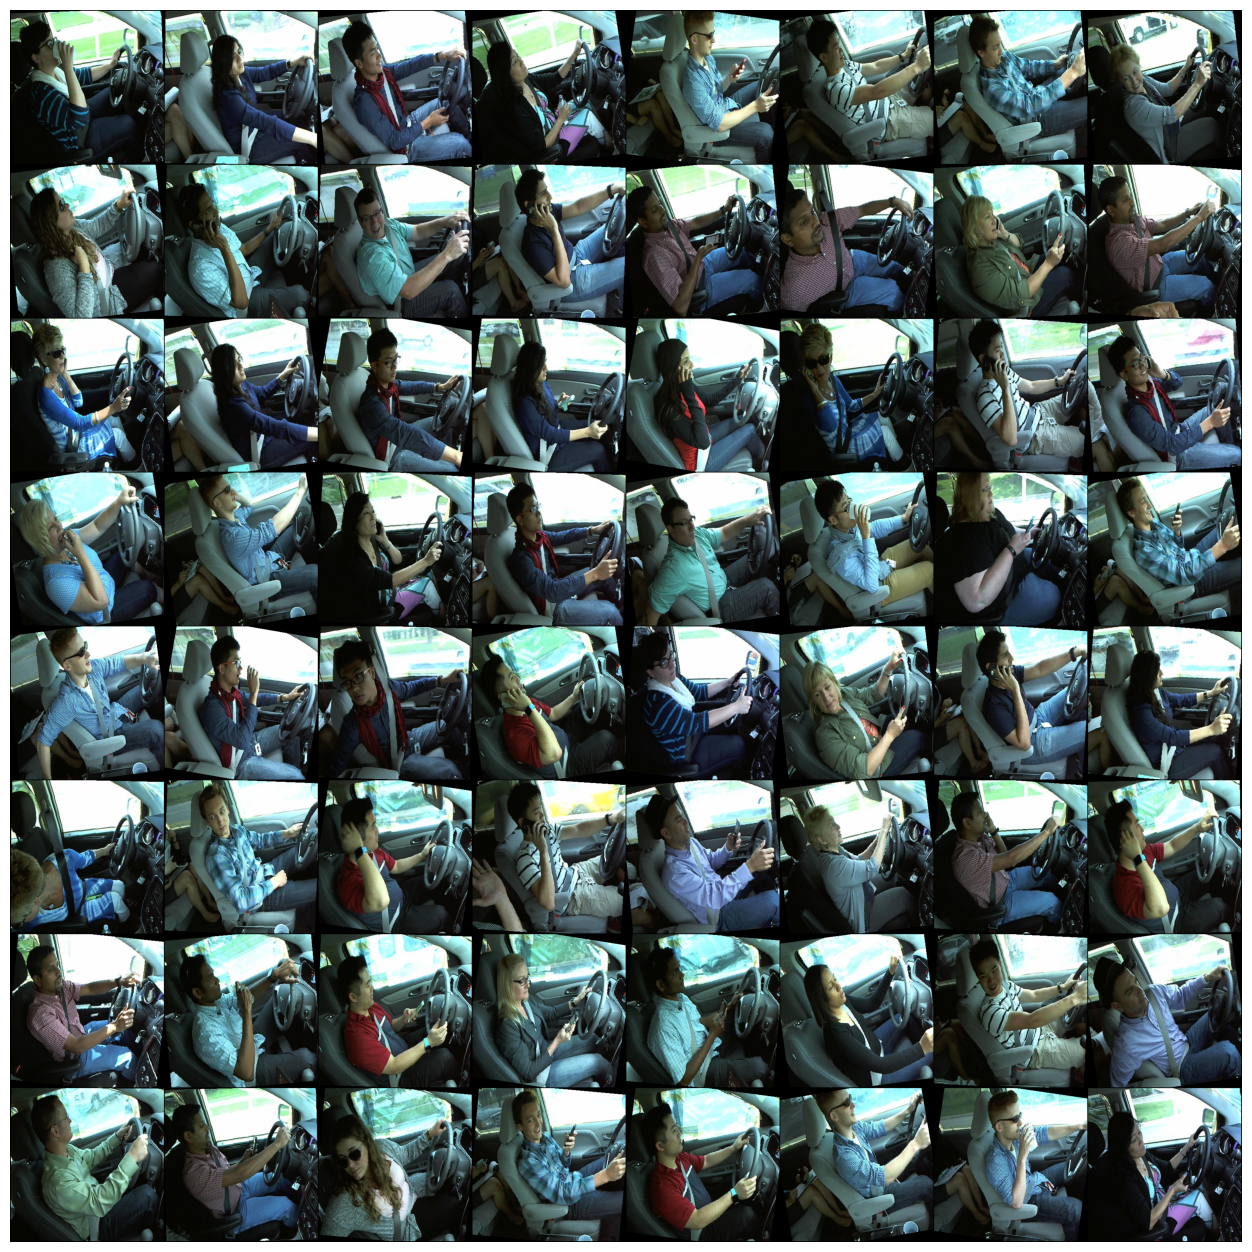

In [26]:
# Loading a Batch of Images and Labels:
loader,labels = next(iter(train_loader))
print(loader.shape)
print(labels.view(8,8))
plt.figure(figsize=(16,16))
# Creates a grid of images. nrow=8 indicates that the grid will have 8 images per row.
# `permute((1,2,0))`: adjusts the dimensions for display in matplotlib (channels last
plt.imshow(torchvision.utils.make_grid(loader,nrow=8).permute((1,2,0)))
plt.axis('off')
plt.show()

## 2. Model Selection / Experiments
We are quite new to this area, so let's do some experiments. James have provided some links he found seems to be helpful.

Resources:
> 1. Tenserflow has a lot of interesting examples here.
https://www.tensorflow.org/lite/examples
One that might be useful for you guys is this gesture recognition one
https://github.com/tensorflow/examples/tree/master/lite/examples/gesture_classification/android

> 2. Also check out the section here on using Google’s TeachableMachines
https://github.com/jfd235/Interactive-Lab-Hub/tree/Fall2022/Lab%205

> 3. These articles seem to point to repositories that already have code in Colab/Jupyter notebook form
https://towardsdatascience.com/tutorial-using-deep-learning-and-cnns-to-make-a-hand-gesture-recognition-model-371770b63a51
https://developers.google.com/mediapipe/solutions/customization/gesture_recognizer

Final Note from James:
> There are a ton of resources out there like this, so I’d pick one that looks easy (the TeachableMachines looks really easy to prototype with IMO), try it with a few of your images for training (no point in using all of them since we’re just testing things for now), and see if they can predict a few of your other images for testing

### 2.1 Experiements Report for those sources
Don't have to be only one assignee.
Assignee:

### 2.2 Creating and training the model

In [5]:
#  Sets the device to a CUDA-enabled GPU (if available) for training.
# "cuda:0" refers to the first GPU.
device = torch.device("cuda:0")
# Prints the device that is being used.
print(device)
# Prints the name of the CUDA device, useful for confirmation and debugging.
print(torch.cuda.get_device_name(device))

cuda:0
Tesla T4


### 2.2.1 Revised Image Transformations
The model works better with 'normalized' data.

In [6]:
# Defines a new transformation pipeline for the images.
transform = transforms.Compose(
    [transforms.Resize((400, 400)),
     transforms.RandomRotation(10),
     transforms.ToTensor(),
# This new step normalizes the image data. 
# The first tuple is the mean and the second is the standard deviation 
# for each of the three color channels. 
# This normalization helps in stabilizing the training process.
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

### 2.2.2 Repeating Dataset Preparation and Data Loaders:
The following code is a repetition of earlier steps with some modifications:
* The batch size is changed to 32 in the data loaders.
* `num_workers=2` is added to the data loaders, which allows for parallel data loading, potentially speeding up the process.

In [19]:
train_loader = torch.utils.data.DataLoader(dataset=training_data,
# The number of images processed in each batch is set to 32.
                                           batch_size=32,
                                           shuffle=True,
                                           drop_last=False,
# Utilizes 2 subprocesses for data loading. 
# This is particularly useful for large datasets and can lead to faster data loading.
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=testing_data,
                                          batch_size=32,
                                          shuffle=False,
                                          drop_last=False,
                                          num_workers=2)

### 2.2.3 Train and evaluate

This code is a comprehensive example of training and evaluating a deep learning model using PyTorch. It defines two functions, train_model and eval_model, for training and evaluating the model, respectively. Then, it prepares a ResNet50 model for training.

The code comprehensively demonstrates a typical process for training a deep learning model in PyTorch, including data loading, model preparation, setting up the loss function and optimizer, and iterating over the dataset for training and evaluation. The use of a learning rate scheduler and the evaluation of model performance after each epoch are key components of an effective training loop.

In [31]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    """This function is responsible for training the model.
    
    Inside the function:
    The model is initially set to train mode.
    For each epoch, the model is trained on the training data, 
    and its performance is evaluated on the test data.
    Losses and accuracies for both training and testing are tracked and printed.

    Args:
        model: The neural network model to be trained.
        criterion: The loss function used for training.
        optimizer: The optimization algorithm used to update the model's weights.
        scheduler: Adjusts the learning rate based on the validation metric.
        n_epochs: Number of training epochs.

    """
    losses = []
    accuracies = []
    test_accuracies = []
    # set the model to train mode initially
    model.train()
    for epoch in tqdm(range(n_epochs)):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for data in train_loader:

            # get the inputs and assign them to cuda
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100/32*running_correct/len(train_loader)

        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

In [33]:
def eval_model(model):
    """This function evaluates the model on the test dataset.
    
    Inside the function:
    The model is set to evaluation mode, disabling features like dropout.
    The function iterates over the test dataset and calculates the model's accuracy.
    The total accuracy is printed and returned.
    
    """
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

In [35]:
# Model Preparation

# A pre-trained ResNet50 model is loaded.
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# The final fully connected layer is replaced 
# to match the number of classes in the dataset (10 in this case).
model_ft.fc = nn.Linear(num_ftrs, 10) #No. of classes = 10
# The model is transferred to the CUDA device for GPU acceleration.
model_ft = model_ft.to(device)

In [36]:
# Loss Function, Optimizer, and Scheduler

# Cross-entropy loss is used, suitable for multi-class classification.
criterion = nn.CrossEntropyLoss()
#  SGD (Stochastic Gradient Descent) optimizer is used with a learning rate of 0.01 and momentum of 0.9.
optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
# A learning rate scheduler is set up to reduce the learning rate based on the plateau in test accuracy.
lrscheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

In [38]:
# Training the Model

# The train_model function is called with the prepared model, criterion, optimizer, scheduler, and number of epochs.
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=3)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1, duration: 610 s, loss: 0.0391, acc: 98.8414


 33%|███▎      | 1/3 [10:57<21:55, 657.50s/it]

Accuracy of the network on the test images: 98 %
Epoch 2, duration: 611 s, loss: 0.0208, acc: 99.3650


 67%|██████▋   | 2/3 [21:56<10:58, 658.26s/it]

Accuracy of the network on the test images: 99 %
Epoch 3, duration: 611 s, loss: 0.0084, acc: 99.6825


100%|██████████| 3/3 [32:54<00:00, 658.21s/it]

Accuracy of the network on the test images: 99 %
Finished Training


### 2.2.4 Visualize the Result

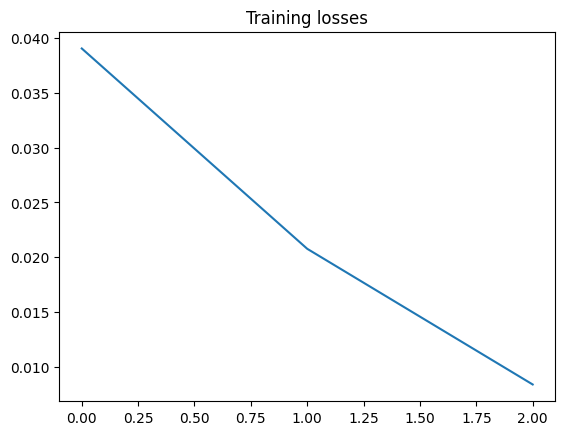

In [39]:
plt.title('Training losses')
plt.plot(training_losses)
plt.show()

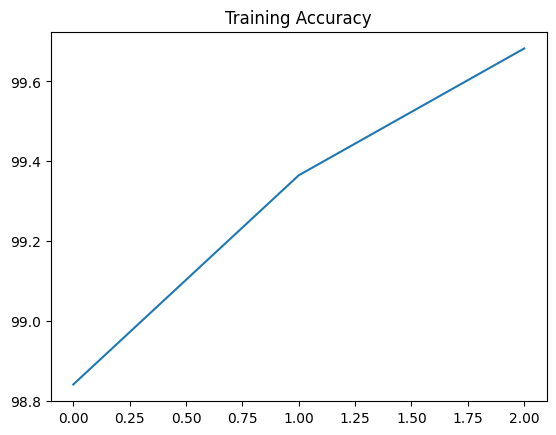

In [40]:
plt.title('Training Accuracy')
plt.plot(training_accs)
plt.show()

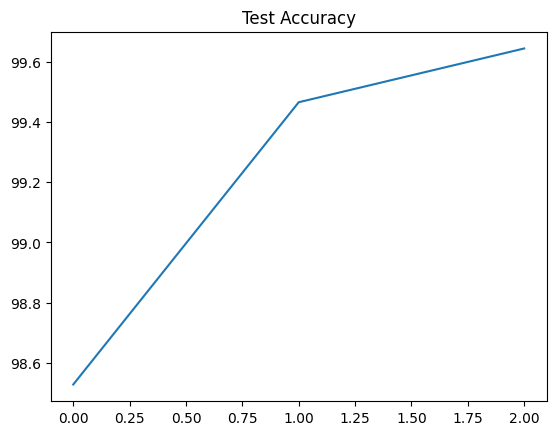

In [41]:
plt.title('Test Accuracy')
plt.plot(test_accs)
plt.show()

### 2.2.5 Save the Result

In [3]:
torch.save(model_ft.state_dict(), "/kaggle/working/model-driver")

NameError: name 'model_ft' is not defined

### 2.3 Testing the model and submitting csv


### 2.3.1 Model Setup


In [10]:
# A new ResNet50 model is created.
model = models.resnet50()
num_ftrs = model.fc.in_features
# The final fully connected layer is modified to output 10 classes, 
# matching the number of classes in the dataset.
model.fc = nn.Linear(num_ftrs, 10)
# The model's weights are loaded from a saved state (model-driver file).
model.load_state_dict(torch.load("/kaggle/input/model2-0/model-driver"))
# model.eval() sets the model to evaluation mode, 
# disabling features like dropout for consistency in predictions.
model.eval()
# moves the model to the GPU for faster computation.
model.cuda()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 2.3.2 Preparing Test Images

In [11]:
path_test = "/kaggle/input/state-farm-distracted-driver-detection/imgs/test"
list_img_test = [img for img in os.listdir(path_test) if not img.startswith(".")]
list_img_test.sort()

### 2.3.3 Displaying a Random Test Image

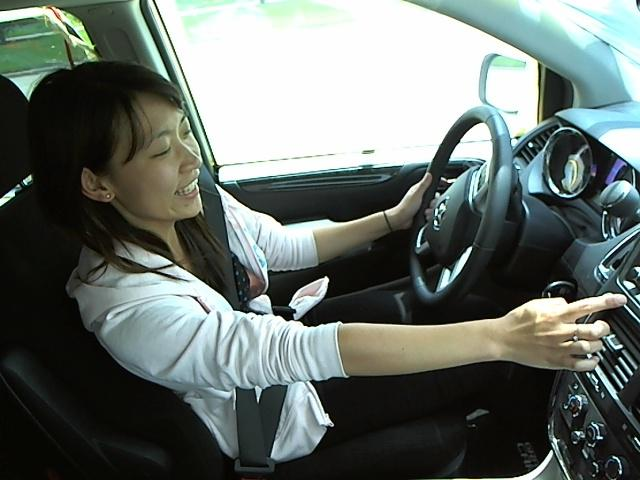

In [12]:
# A random image filename is chosen from the list of test images.
file = random.choice(list_img_test)
im_path = os.path.join(path_test, file)
# The selected image is displayed.
display(Image(filename=im_path))

### 2.3.4 Image Processing and Model Prediction

In [13]:
with PIL.Image.open(im_path) as im:
# The chosen image is opened and transformed
# using the previously defined transformations (e.g., resizing, normalization).
    im = transform(im)
# Adds a batch dimension, as the model expects batched input.
    im = im.unsqueeze(0)
# The image tensor is moved to the GPU and passed through the model to get the output.
    output = model(im.cuda())
# Applies the softmax function to the model output to convert it into class probabilities.
    proba = nn.Softmax(dim=1)(output)
# The probabilities are rounded and printed.
    proba = [round(float(elem),4) for elem in proba[0]]
    print(proba)
# The class with the highest probability is identified as the predicted class.
# The confidence of the prediction (highest probability) is printed.
    print("Predicted class:",class_dict[proba.index(max(proba))])
    print("Confidence:",max(proba))
# A secondary prediction is made by zeroing out the highest probability and identifying the next highest.
    proba2 = proba.copy()
    proba2[proba2.index(max(proba2))] = 0.
    print("2nd answer:",class_dict[proba2.index(max(proba2))])
    print("Confidence:",max(proba2))

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Predicted class: operating the radio
Confidence: 1.0
2nd answer: safe driving
Confidence: 0.0


In [20]:
def true_pred(test_data,model):
    y_true = []
    y_pred = []
    n = len(test_data)
    sum = 0
    # torch.no_grad() is used to disable gradient calculations,
    # saving memory and computations during inference.
    with torch.no_grad():
    # Iterates over the test data
        for x,y in tqdm(test_data):
    # moving the inputs to the GPU.
            x = x.to(device)
    # torch.argmax(model(x), dim=1) gets the index of the maximum value in the output tensor,
    # representing the predicted class.
    # representing the predicted class.
            pred = torch.argmax(model(x),dim=1)
    # y_true and y_pred lists are filled with actual and predicted labels, respectively.
            y_true.extend(list(np.array(y)))
            y_pred.extend(list(np.array(pred.cpu())))
    # Returns the lists of actual (y_true) and predicted (y_pred) labels for the test dataset.
    return y_true,y_pred

In [21]:
# Model Evaluation

# Calls the previously defined function true_pred with the test_loader and the model.
# This function returns the true labels (y_true) 
# and the predicted labels (y_pred) for the test dataset.
y_true,y_pred = true_pred(test_loader,model)

100%|██████████| 141/141 [00:44<00:00,  3.15it/s]


In [22]:
# Confusion Matrix:

# Generates a confusion matrix from the true and predicted labels. 
# A confusion matrix is a table used to evaluate the performance of a classification algorithm.

# The matrix m is normalized by dividing each row by the sum of its elements. 
# This normalization allows for a better comparison between classes, 
# especially when the number of samples in each class varies.
m = confusion_matrix(y_true, y_pred)
m = m.astype('float') / m.sum(axis=1)[:, np.newaxis]


<Axes: >

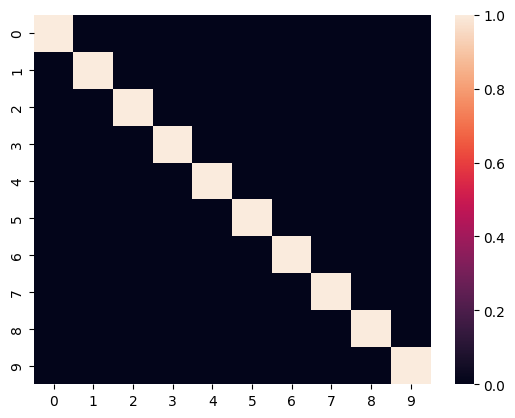

In [23]:
# Heatmap Visualization

# Uses Seaborn's heatmap function to visualize the confusion matrix. 
# Heatmaps are useful for visualizing the performance of a classifier, 
# where brighter colors can indicate higher numbers or rates.
sns.heatmap(m)

In [24]:
# Preparing Test Data for Faster Processing:

# This restructuring is done to make the test data compatible with datasets.ImageFolder, 
# which expects data to be in a directory structure 
# where each subdirectory represents a class. 
# This can significantly speed up loading and processing test images compared 
# to processing them one by one.
os.mkdir("/kaggle/working/test")
for img in tqdm(list_img_test):
    os.mkdir("/kaggle/working/test/"+img[:-4])
    source = path_test+"/"+img
    destination = "/kaggle/working/test/"+img[:-4]+"/"+img
    shutil.copy(source, destination)


100%|██████████| 79726/79726 [21:43<00:00, 61.16it/s]  


In [1]:
# Defining Image Transformations for Testing


# `transforms.Compose`: A method to chain together several image transformations.
transform_test = transforms.Compose([
# Resizes each image to 400x400 pixels.
    transforms.Resize((400, 400)),
# This line is commented out, meaning rotation is not applied in this test transformation.
    #transforms.RandomRotation(10),
# Converts the images to PyTorch tensors.
    transforms.ToTensor(),
# Normalizes the image data. 
# The given mean and standard deviation are applied to each of the three color channels.
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


NameError: name 'transforms' is not defined

In [ ]:
# Loading the Test Dataset

root = "/kaggle/working/test": Sets the path to the test data.
transform = transform_test: Applies the defined transformations to the images.
# datasets.ImageFolder: A PyTorch dataset loader that expects data in a directory structure 
# with subfolders representing classes.
datatest = datasets.ImageFolder(root = "/kaggle/working/test",
# Applies the defined transformations to the images.
                                transform = transform_test)


In [ ]:
# Creates a DataLoader for the test dataset.


loader = torch.utils.data.DataLoader(dataset=datatest,
# batch_size=16: Processes 16 images at a time.
                                     batch_size=16,
# shuffle=False: Since this is for testing, shuffling the data is not necessary.
                                     shuffle=False,
# drop_last=False: Ensures that the last batch is used, even if it's smaller than the specified batch size.
                                     drop_last=False,
# num_workers=2: Utilizes 2 subprocesses for data loading to potentially speed up the process.
                                     num_workers=2)


In [ ]:
# Retrieving and Visualizing a Batch of Images:

# Retrieves the first batch of images (x) and their corresponding labels (y) from the DataLoader.
x, y = next(iter(loader))
print(x.shape)
print(y)
plt.figure(figsize=(16,16))
# Creates a grid of images from the batch. nrow=8 specifies that the grid should have 8 images per row.
# permute((1,2,0)): Changes the order of the dimensions 
# to make the tensor compatible with the expected input format of matplotlib.pyplot.imshow.
plt.imshow(torchvision.utils.make_grid(x, nrow=8).permute((1,2,0)))
plt.axis('off')
plt.show()


### 2.3.5 Save outputs

In [ ]:
# Loading the Submission Template:

df = pd.read_csv("/kaggle/input/state-farm-distracted-driver-detection/sample_submission.csv", index_col = 0)

In [ ]:
# Generating Predictions:

line = 0
for x, y in tqdm(loader, total = len(loader)):
# model_ft(x.cuda()): Passes the batch of images through the model for prediction. 
# The images are moved to the GPU with .cuda().
    output = model_ft(x.cuda())
# nn.Softmax(dim=1)(output): 
# Applies the softmax function to convert the model outputs into probabilities.
    output = nn.Softmax(dim=1)(output)
    for i in range(len(output)):
# Converts the probabilities to a list of floating-point numbers.
        proba = [float(elem) for elem in output[i]]
# Assigns the probabilities to the corresponding line in the DataFrame.
        df.iloc[line][:] = proba
        line += 1


In [ ]:
# Cleaning Up the Test Data Directory:

for img in tqdm(list_img_test):
    os.remove("/kaggle/working/test/"+img[:-4]+"/"+img)
    os.rmdir("/kaggle/working/test/"+img[:-4])
os.rmdir("/kaggle/working/test")


In [ ]:
# Saving the Submission File:

df.to_csv("/kaggle/working/submission.csv")